In [1]:
# !pip install -U iminizinc

In [2]:
# Import the necessary libraries
from tqdm import tqdm
from utils import import_instances, plot_solution, output_solution
%reload_ext iminizinc

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.5.5, build 273041792
Copyright (C) 2014-2021 Monash University, NICTA, Data61


## Data Import

In [3]:
# Get all instances from text files
instances = import_instances('input/instances/')
print(f'Number of instances: {len(instances)}')

Number of instances: 40


## Constraint Programming

In [4]:
def get_variables(NUMBER):
    # Get the number of blocks
    BLOCKS = []
    for n in range(int(instances[NUMBER][1])):
        BLOCKS.append(f'Block {n}')
    
    # Get block lengths and heights
    BLOCK_WIDTHS = []
    BLOCK_HEIGHTS = []

    for value in instances[NUMBER][2:]:
        width, height = value.split(' ')
        BLOCK_WIDTHS.append(int(width))
        BLOCK_HEIGHTS.append(int(height))
    
    # Get the maximum width and height
    MAX_WIDTH = int(instances[NUMBER][0])
    MAX_HEIGHT = sum(BLOCK_HEIGHTS)
    
    return BLOCKS, BLOCK_WIDTHS, BLOCK_HEIGHTS, MAX_WIDTH, MAX_HEIGHT

In [5]:
%%mzn_model model

include "globals.mzn";

enum BLOCKS;
array[BLOCKS] of int: BLOCK_WIDTHS;
array[BLOCKS] of int: BLOCK_HEIGHTS;

int: MAX_WIDTH;
int: MAX_HEIGHT;

% Constraints to find y-coordinates
array[BLOCKS] of var 0..MAX_HEIGHT: start_y;
var 0..MAX_HEIGHT: end_y;

constraint cumulative(start_y, BLOCK_HEIGHTS, BLOCK_WIDTHS, MAX_WIDTH);

constraint forall(b in BLOCKS)(start_y[b] + BLOCK_HEIGHTS[b] <= end_y);

% Constraints to find x-coordinates
array[BLOCKS] of var 0..MAX_WIDTH: start_x;

constraint cumulative(start_x, BLOCK_WIDTHS, BLOCK_HEIGHTS, end_y);

constraint forall(b in BLOCKS)(start_x[b] + BLOCK_WIDTHS[b] <= MAX_WIDTH);

solve minimize end_y;

In [6]:
# Show the solution found
def show_solution(start_x, start_y, end_y, file=None):
    # Print the output
    if file is None:
        print(f'Minimum height: {end_y}')
        print(f'Location x: {start_x}')
        print(f'Location y: {start_y}')
    
    # Plot the solution found
    circuits = []
    for i in range(len(BLOCKS)):
        circuits.append([BLOCK_WIDTHS[i], BLOCK_HEIGHTS[i], start_x[i], start_y[i]])

    plot_solution(MAX_WIDTH, end_y, len(BLOCKS), circuits, file)

Minimum height: 17
Location x: [11, 14, 11, 14, 14, 4, 11, 7, 0, 7, 0, 0]
Location y: [14, 13, 9, 7, 0, 0, 0, 14, 0, 0, 14, 8]


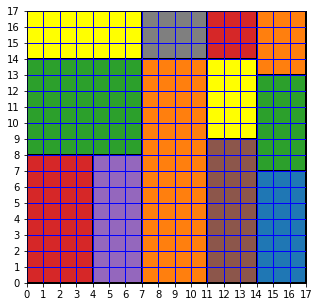

In [7]:
# Show a sample solution
NUMBER = 1
BLOCKS, BLOCK_WIDTHS, BLOCK_HEIGHTS, MAX_WIDTH, MAX_HEIGHT = get_variables(NUMBER)
%minizinc model --time-limit 60000 -m bind 
show_solution(start_x, start_y, end_y)

## Data Output

In [8]:
for n in tqdm(range(len(instances))):
    NUMBER = n
    BLOCKS, BLOCK_WIDTHS, BLOCK_HEIGHTS, MAX_WIDTH, MAX_HEIGHT = get_variables(NUMBER)
    %minizinc model --time-limit 60000 -m bind
    output_solution(instances[NUMBER], start_x, start_y, end_y, f'output/CP/solutions/out-{NUMBER}.txt')
    show_solution(start_x, start_y, end_y, f'output/CP/pictures/out-{NUMBER}.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [30:12<00:00, 45.30s/it]
